<a href="https://colab.research.google.com/github/lorransr/tripdetection/blob/master/EDA_Trips.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDA Trips

Esse notebook visa realizar uma análise inicial dos dados a respeito das viagens de carro monitoradas através do aplicativo *sensor-record*. O objetivo no presente momento consiste em identificar através do estado normal de descanso do veículo um posicionamento padrão e, a partir do mesmo poder dizer, através do desvio dessa posição padrão qual movimento esta sendo executado no carro a cada momento.

A princípio estou tirando as ideias desse artigo [aqui](https://www.hindawi.com/journals/misy/2017/9075653/)

## Importando Arquivos

In [0]:
import pandas as pd
import numpy as np
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt

In [0]:
root = "https://raw.githubusercontent.com/lorransr/tripdetection/master/Trips"
folders = ["2019-08-21_19-24-53"]
files = ["Accelerometer","AccelerometerLinear","GPS","Gyroscope"]
urls = []
for folder in folders:
  for file in files:
    urls.append(root+"/"+folder+"/"+file+".csv")

## Dados do Acelerômetro

In [0]:
raw_acc = pd.read_csv(urls[0])

In [0]:
def set_ts(raw):
  df = raw.copy()
  df.Timestamp = pd.to_datetime(df.Timestamp)
  df.Milliseconds = pd.to_timedelta(df.Milliseconds,"ms")

  df["ts"] = df.Timestamp.iloc[0]+df.Milliseconds
  df.drop(["Timestamp","Milliseconds"],axis=1,inplace=True)
  df.set_index("ts",inplace=True)
  return df

In [0]:
acc = set_ts(raw_acc)

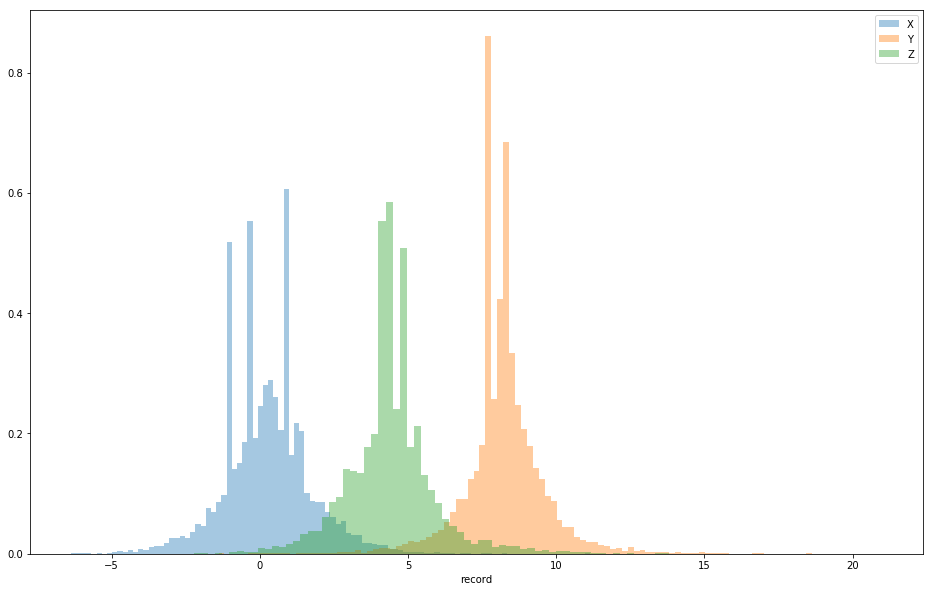

In [101]:
#visualizando destribuições
plt.figure(figsize=(16,10))
sns.distplot(acc["X"],kde=False,norm_hist=True,bins=100,label="X")
sns.distplot(acc["Y"],kde=False,norm_hist=True,bins=100,label="Y")
sns.distplot(acc["Z"],kde=False,norm_hist=True,bins=100,label="Z")
plt.xlabel("record")
plt.legend()

Nesta primeira viagem, o celular foi colocado no carro em posição vertical com a tela voltada para parte interna do veículo, levemente inclinado na mesma direção. Isso pode ser observado através do valor de $Y$ que é, próximo de $g$

In [102]:
acc.Y.mean()

8.19656401285625

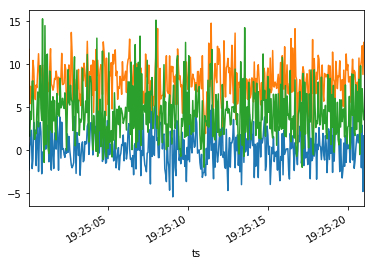

In [103]:
acc["2019-08-21 19:25:00":"2019-08-21 19:25:20"].X.plot()
acc["2019-08-21 19:25:00":"2019-08-21 19:25:20"].Y.plot()
acc["2019-08-21 19:25:00":"2019-08-21 19:25:20"].Z.plot()

## Média Movel

De forma a atenuar o ruido dos dados, realizei uma operação de Média Movel, com dados janelados em 5 segundos, com uma janela triangular.

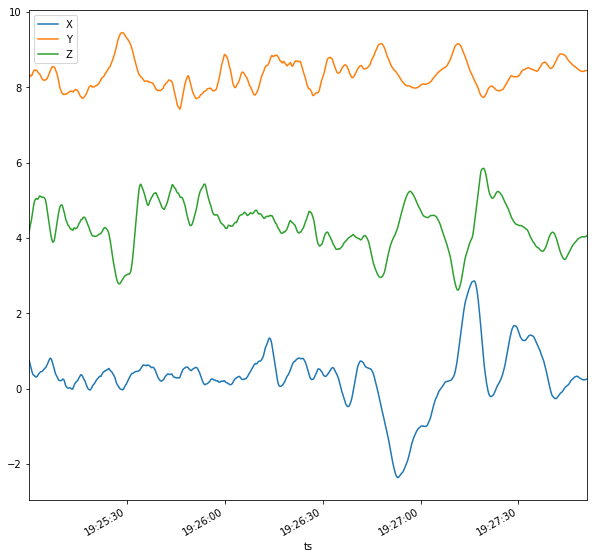

In [104]:
plt.figure(figsize=(10,10))
acc_rolling = acc.rolling(100,win_type="triang").mean()
acc_rolling["2019-08-21 19:25:00":"2019-08-21 19:27:50"].X.plot()
acc_rolling["2019-08-21 19:25:00":"2019-08-21 19:27:50"].Y.plot()
acc_rolling["2019-08-21 19:25:00":"2019-08-21 19:27:50"].Z.plot()
plt.legend()

In [0]:
# from sklearn import preprocessing
# scaler = preprocessing.StandardScaler()
# scaled_array = scaler.fit_transform(acc_rolling)

# acc_norm = pd.DataFrame(scaled_array,index=acc_rolling.index, columns=acc_rolling.columns)

In [0]:
# plt.figure(figsize=(10,10))
# acc_norm["2019-08-21 19:25:00":"2019-08-21 19:27:50"].X.plot()
# acc_norm["2019-08-21 19:25:00":"2019-08-21 19:27:50"].Y.plot()
# acc_norm["2019-08-21 19:25:00":"2019-08-21 19:27:50"].Z.plot()
# plt.legend()

## Transferência de Coordenadas

Quando realizando uma viagem, o smartphone pode estar posicionado em qualquer orientação dentro do veículo. Com isso em vista, tem-se dois sistemas de coordenadas dentro do Veículo. Um para o veículo propriamente dito ($x$, $y$, $z$), e o outro para o celular($X$, $Y$, $Z$). Então, de forma a obter resultados relevantes a respeito das medições do aparelho smartphone, é necessário alinhar as coordenadas do aparelho com a do veículo. 
De acordo com [alguns trabalhos](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/Nericell-Sensys2008.pdf) uma forma de se obter os angulos de rotação, é travez dos Angulos de Euler. A princípio, qualquer orientação do acelerometro pode ser representada por uma pré-rotação de $\phi_{pre}$ no eixo $Z$, seguida de um tilt em $\theta_{tilt}$ no eixo $Y$ e por fim uma pós-rotação de $\psi_{pos}$ novamente em $Z$. Todos os angulos são medidos de forma anti-horária, em seus respectivos eixos.
Embora não façamos explicitamente uma rotação em $X$, justamente por conta da pré-rotação, o tilt afeta tanto x e y. Por exemplo, se a pré-rotação for de 90, y seria uma linha com X, dessa forma, o tilt em Y afetaria y também.

---

Quando o acelerômetro está estacionário ou em velocidade constante, a unica aceleração captada pelo sensor será a gravidade, na direção Z. A operação de tilt é a unica que muda a orientação de z, em relação a Z. Então $a_z = a_Zcos(\theta_{tilt})$. Uma vez que $a_Z = 1$(1g), temos:

>$\theta_{tilt} = cos^{-1}(a_z)$

A pré-rotação também resulta em um $a_x$ e um $a_y$ não nulos devido ao efeito da gravidade. Dessa forma tem-se:

>$\phi_{pre} = tan^{-1}(\frac{a_y}{a_x})$

De forma a estimar $\theta_{tilt}$ e $\phi_{pre}$ nós deveriamos identificar periodos onde o telefone está estacionário. No entanto, uma abordagem mais simples seria trabalhar com os valores medianos de $a_x$,$a_y$ e $a_z$, em janelas de 10 segundos. 




In [95]:
acc.index[200]-acc.index[0]

Timedelta('0 days 00:00:09.999000')

In [0]:
acc_rolling = acc.rolling(200,1).median()/9.81 #janelando dados e colocando em força G

In [0]:
acc["theta"] = np.arccos(acc_rolling.Z)
acc["phi"] = np.arctan(acc_rolling.Y/acc_rolling.Z)

## Estimando Pós-Rotação

Uma vez que a pós-rotação, se dá em torno de Z, ela não é afetada pelo campo gravitacional, que possui uma orientação não paralela a Z. Para podermos estimar o angulo de pós rotação, $\psi_{pos}$. De fato, será necessário uma força que possua uma componente em uma direção ortogonal a Z.

Aceleração e a frenagem de um veiculo em uma linha reta, produzem uma força em uma direção X, na mesma linha de direção do movimento do veículo. No entanto, esses teriam pouco impacto nas direções ortogonais, particularmente em Y. De forma geral, frenagens possuem uma assinatura mais forte que acelerações. Se um carro viaja a 50 km/h e reduz até parar em 10 segundos, $a_x$ será em torno de $0.14g$, pequeno porém ainda notavel. 

Dessa forma, nós usamos o GPS para monitoras periodos de desacelerações e sem curvas significantes no caminho (ex.:o caminho do GPS sendo praticamente linear). Durante esse periodo, sabemos que haverá uma força na direção X, com pouco impacto em Y. Dados as medidas de aceleração ($a_x$, $a_y$,$a_z$) e os angulos de pré-rotação e tilt, é possivel estimar o angulo de pós-rotação, como aquele que mximiza nossa estimativa de $a^{'}_{x}$. 

>$\psi_{pos} = tan^{-1}(\frac{-a_xsin(\phi_{pre})+a_ycos(\phi_{pre})}{(a_xcos(\phi_{pre})+a_ysin(\phi_{pre}))cos(\theta_{tilt})-a_zsin(\theta_{tilt})})$

Comparado a estimativa de $\phi_{pre}$ e $\theta_{tilt}$, estimar $\psi_{pos}$ é mais elaborado, chegando a necessitar do GPS.


Por fim a matriz de  rotação se dá por:

>$R  = R(\phi_{pre})R(\theta_{tilt})R(\psi_{pos})$

>$R(\phi_{pre}) = \bigl(\begin{smallmatrix}
1 & 0 & 0\\ 
0 & cos\phi_{pre} & sin\phi_{pre} \\ 
0 & -sin\phi_{pre} & cos\phi_{pre}
\end{smallmatrix}\bigr)$,
>$R(\theta_{tilt}) = \bigl(\begin{smallmatrix}
cos\theta_{tilt} & 0 & -sin\theta_{tilt}\\ 
0 & 1 & 0 \\ 
sin\theta_{tilt} & 0 & cos\theta_{tilt}
\end{smallmatrix}\bigr)$,
>$R(\psi_{pos}) = \bigl(\begin{smallmatrix}
cos\psi_{pos} & sin\psi_{pos} & 0\\ 
-sin\psi_{pos} & cos\psi_{pos}& 0 \\ 
0 & 0 & 1
\end{smallmatrix}\bigr)$

<!--Para isso é necessário encontrar os angulos de rotação $\alpha$, $\beta$ e $\gamma$. Com base nesses angulos é possivel determinar a matrix de rotação R, que alinha o sistema de coordenadas do telefone com o do carro.

Sendo $g$ a aceleração da gravidade. Os ângulos da coordenada do telefone na direção vertical são $\alpha^{'}$, $\beta^{'}$ e $\gamma^{'}$. Quando o veículo se move em velocidade constante, a medição da aceleração é tida em termos da projeção da aceleração da gravidade. Os valores da aceleração nos três eixos são: $a_x$, $a_y$, $a_z$. Dessa forma:

>$\alpha^{'} = \frac{a_x}{g}$

>$\beta^{'} = \frac{a_y}{g}$

>$\gamma^{'} = \frac{a_z}{g}$

De acordo com a [figura](https://www.hindawi.com/journals/misy/2017/9075653/fig7/), é possivel determinar os angulos de rotação $\beta = |\alpha^{'} - \beta^{'}|$, $\alpha = \gamma^{'}$. Temos então que $R = R(\gamma)R(\beta)R(\alpha)$. Utilizamos a seguinte equação para encontrar $\gamma$.

>$\bigl(\begin{smallmatrix}
0\\ 
0\\ 
0
\end{smallmatrix}\bigr) = R(\gamma)R(\beta)R(\alpha) \bigl(\begin{smallmatrix}
a_x\\ 
a_y\\ 
a_z
\end{smallmatrix}\bigr)$

onde, 

-->